# Quotes
## Details
> Een  citaat  benadrukt  een  belangrijk  deel  van  het artikel,  waardoor  het  de  lezers  prikkelt  om  ook  het achterliggende verhaal te willen lezen.
## Example
> Pakkende  getuigenis  van  ex-gevangene: "In  de cel hingen de muren vol stront"

## Data

In [1]:
from util import get_cls_train_test

train_x, train_y, test_x, test_y = get_cls_train_test("Quotes")
train_y.value_counts()

0    469
1    212
Name: Quotes, dtype: int64

## Approach 1: All headlines containing quotation mark

In [4]:
def contains_quotation_mark(text):
    return "\"" in text

f-score: 0.9645390070921985
Confusion matrix: (TP: 155, FP: 5, FN: 0, TN: 68)
Accuracy=97.81% (223/228)


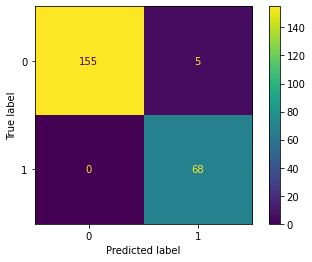

In [14]:
from util import print_evaluation
predictions = test_x.apply(contains_quotation_mark).apply(lambda x: int(x)) # also convert bool to int
print_evaluation(test_y, predictions)

As expected, this trivial solutions performs quite good. Let’s see at the misclassifications in our training data:

In [15]:
import numpy as np
# False positives:
predict = np.vectorize(contains_quotation_mark)(train_x)
train_x[(predict != train_y) & (predict == 1)][:5]

Test      
149   387     "Iedereen" krijgt psycholoog terugbetaald... b...
333   840     Stranden populaire vakantiebestemming overspoe...
820   2047    De Amerikaan die streed voor vrouwenrechten en...
164   430     "Kwetsbare" Luc (57) spoorloos na bezoek aan L...
579   1451    Het (slechte) rapport van Jani's 'Matchmakers'...
Name: Headline, dtype: object

## Approach 2: Tf-Idf + Quotation as feature
This probably won't work, but still trying since tf-idf sometimes does some magic.

f-score: 0.9645390070921985
Confusion matrix: (TP: 155, FP: 5, FN: 0, TN: 68)
Accuracy=97.81% (223/228)


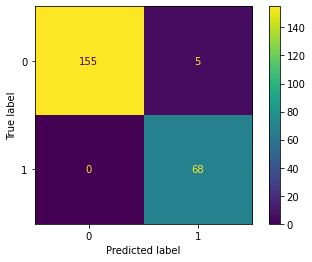

In [18]:
from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from imblearn.combine import SMOTETomek

from util import FunctionTransformer, fit_predict_evaluate
model = Pipeline([
    ('union', FeatureUnion([
        ('vectorizer', TfidfVectorizer()),
        ('quotation_mark', FunctionTransformer(contains_quotation_mark))
    ])),
    ('resampler', SMOTETomek(random_state=0)),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

As expected, the tf-idf didn't make any difference.

### Approach 3: Tf-Idf + Quotation as feature + #Words in quotation as feature
The words inside the quotation brackets might also be an interesting feature.

In [19]:
import re

def get_quotation_words(text):
    return re.findall(r'"([^"]*)"', text)

def get_num_words(text):
    return len(text.split())

def get_quotation_word_count(text):
    # Returns the #words of the longest quote in the text
    quotes = get_quotation_words(text)
    quotes_length = list(map(get_num_words, quotes))
    return max(quotes_length) if quotes_length else 0

sentence = 'En hij zei "Leef!", "Alsof het je laatste dag is!"' # Should return 6, since the longest quote has 6 words
get_quotation_word_count(sentence)

6

f-score: 0.9645390070921985
Confusion matrix: (TP: 155, FP: 5, FN: 0, TN: 68)
Accuracy=97.81% (223/228)


C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


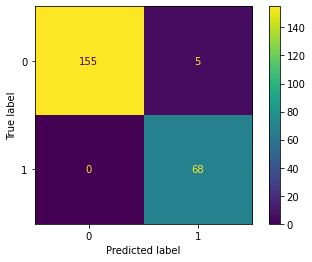

In [25]:
model = Pipeline([
    ('union', FeatureUnion([
        ('vectorizer', TfidfVectorizer()),
        ('quotation_mark', FunctionTransformer(contains_quotation_mark)),
        ('words_between_quotes', FunctionTransformer(get_quotation_word_count))
    ])),
    ('resampler', SMOTETomek(random_state=0)),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

Strangely, this doesn't seem to make a difference.

### Approach 4: Tf-Idf + Quotation as feature + #quotation words + whether there is a double point
Adding whether there is a double point in a headline might also be an interesting feature (since quotes are often preceeded with that)

In [27]:
def contains_double_point(text):
    return ":" in text

f-score: 0.9714285714285714
Confusion matrix: (TP: 156, FP: 4, FN: 0, TN: 68)
Accuracy=98.25% (224/228)


C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


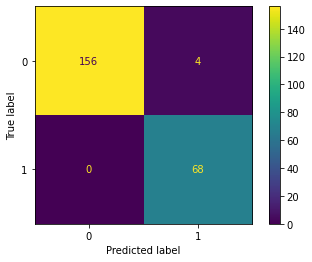

In [28]:
model = Pipeline([
    ('union', FeatureUnion([
        ('vectorizer', TfidfVectorizer()),
        ('quotation_mark', FunctionTransformer(contains_quotation_mark)),
        ('words_between_quotes', FunctionTransformer(get_quotation_word_count)),
        ('double_point', FunctionTransformer(contains_double_point))
    ])),
    ('resampler', SMOTETomek(random_state=0)),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

A slight increase :)